In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy import stats
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Activation

In [2]:
(X_train, Y_train),(X_test, Y_test) = imdb.load_data(path= "imdb.npz",
                                      num_words= None, # tüm kelmieleri alıyoruz bu şekilde sayı verseydik en çok kullanılan istenilen sayıda kelimeyi verecekti.
                                      skip_top= 0,  # en sık kullanılan kelimeleri göz ardı etmemeyi seçtik
                                      maxlen= None,  # çok uzun bir metni istenilen kelime saysısı kadar kırpabiliriz bu parametre ile.
                                      seed = 113,    # random_state ile aynı işleve yarıyor shuffle sırasında karıştırma oranını sabit tutuyoruz keras dökümantasyonunda 113 kullanılıdığı için öyle seçtik
                                      start_char= 1, # metine başlanacak karakter keras dökümantasyonunda 1 önerilmiş
                                      oov_char= 2,   # default
                                      index_from= 3) # default

In [3]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print("Type: ", type(X_train))

(25000,)
(25000,)
(25000,)
(25000,)
Type:  <class 'numpy.ndarray'>


### EDA

In [4]:
print("Y train values: ", np.unique(Y_train))
print("Y test values : ", np.unique(Y_test))

Y train values:  [0 1]
Y test values :  [0 1]


In [5]:
unique, counts= np.unique(Y_train, return_counts= True)
print("Y train distribution: ", dict(zip(unique, counts)))

unique, counts= np.unique(Y_test, return_counts= True)
print("Y test distribution: ", dict(zip(unique, counts)))

Y train distribution:  {0: 12500, 1: 12500}
Y test distribution:  {0: 12500, 1: 12500}


In [6]:
d= X_train[0]

review_len_train= []
review_len_test = []

for i, ii in zip(X_train, X_test):
    review_len_train.append(len(i))
    review_len_test.append(len(ii))

In [7]:
df= pd.DataFrame(review_len_train)
df.sort_values(0)

,0
7301,11
6719,11
12759,12
17904,13
13879,13
...,...
2453,1629
9157,1733
3972,1851
13494,1854


C:\Users\EBRU\AppData\Local\Temp\ipykernel_15760\1597894238.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(review_len_train, hist_kws= {"alpha": 0.1})
C:\Users\EBRU\AppData\Local\Temp\ipykernel_15760\1597894238.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(review_len_test, hist_kws= {

<AxesSubplot:ylabel='Density'>

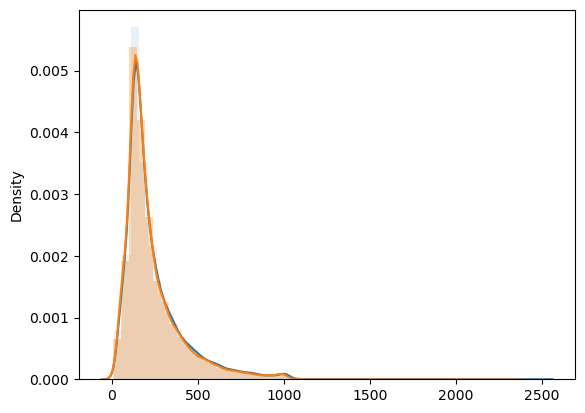

In [8]:
sns.distplot(review_len_train, hist_kws= {"alpha": 0.1})
sns.distplot(review_len_test, hist_kws= {"alpha": 0.3})

In [9]:
print("Train mean: ", np.mean(review_len_train))
print("Train median: ", np.median(review_len_train))
print("Train mode: ", stats.mode(review_len_train))

Train mean:  238.71364
Train median:  178.0
Train mode:  ModeResult(mode=array([132]), count=array([196]))


Yorumlar üzerinde inceleme yapabilmek için her yorumun sabit sayıda kelime içermesi gerekir. Burada train modunun 132 olduğunu yani en çok tekrar eden kelime sayısının 132 oluğunu anlıyoruz. Şimdi kelime sayısı çok olan yorumlar azaltılacak, kelime sayısı az olan yorumlar ise doldurulacak ve bir değerde sabitlenecek.

In [10]:
# number of words
word_index = imdb.get_word_index()
print(type(word_index))
len(word_index)
#word_index.items()

<class 'dict'>


88584

In [11]:
for keys, values in word_index.items():
    if values == 22:
        print(keys)

you


In [12]:
def whatItSay(index = 24):
    reverse_index= dict([(value, key) for (key, value) in word_index.items()])
    #print(reverse_index)
    decode_review= " ".join([reverse_index.get(i-3, "!") for i in X_train[index]])
    print(decode_review)
    print(Y_train[index])
    return decode_review

decoded_review = whatItSay(1)

! big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their stomachs sickening that men actually wore them and the music is just synthesiser trash that plays over and over again in almost every scene there is trashy music boobs and paramedics taking away bodies and the gym still doesn't close for bereavement all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then
0


### Preprocessing

In [13]:
num_words = 15000
(X_train, Y_train),(X_test, Y_test) = imdb.load_data(num_words= num_words)
maxlen = 130
X_train = pad_sequences(X_train, maxlen= maxlen)
X_test= pad_sequences(X_test, maxlen= maxlen)

In [14]:
for i in X_train[0:10]:
    print(len(i))

130
130
130
130
130
130
130
130
130
130


In [15]:
X_train[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
        778,  128,   74,   12,  630,  163,   15,    4, 1766, 7982, 1051,
          2,   32,   85,  156,   45,   40,  148,  139,  121,  664,  665,
         10,   10, 1361,  173,    4,  749,    2,   16, 3804,    8,    4,
        226,   65,   12,   43,  127,   24,    2,   10,   10])

In [16]:
decoded_review = whatItSay(5)

! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! begins better than it ends funny that the russian submarine crew ! all other actors it's like those scenes where documentary shots br br spoiler part the message ! was contrary to the whole story it just does not ! br br
0


ünlemler bilinmeyen kelimeleri ifade etmektedir.

### RNN

In [19]:
rnn = Sequential()
rnn.add(Embedding(num_words, 32, input_length= len(X_train[0])))
rnn.add(SimpleRNN(16, input_shape= (num_words, maxlen), return_sequences= False, activation= "relu"))
rnn.add(Dense(1))
rnn.add(Activation("sigmoid")) # binary classification olduğu için sigmoid

print(rnn.summary())
rnn.compile(loss= "binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           480000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 480,801
Trainable params: 480,801
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history= rnn.fit(X_train, 
                Y_train, 
                validation_data= (X_test, Y_test), 
                epochs= 5, 
                batch_size= 128, 
                verbose= 1)

Epoch 1/5
196/196 [==============================] - 57s 265ms/step - loss: 0.6470 - accuracy: 0.6406 - val_loss: 0.5298 - val_accuracy: 0.7755
Epoch 2/5
196/196 [==============================] - 72s 366ms/step - loss: 0.4661 - accuracy: 0.8265 - val_loss: 0.4298 - val_accuracy: 0.8300
Epoch 3/5
196/196 [==============================] - 64s 325ms/step - loss: 0.3377 - accuracy: 0.8692 - val_loss: 0.4131 - val_accuracy: 0.8243
Epoch 4/5
196/196 [==============================] - 63s 323ms/step - loss: 0.2681 - accuracy: 0.8969 - val_loss: 0.3375 - val_accuracy: 0.8581
Epoch 5/5
196/196 [==============================] - 64s 324ms/step - loss: 0.2325 - accuracy: 0.9104 - val_loss: 0.3933 - val_accuracy: 0.8399


In [21]:
score= rnn.evaluate(X_test, Y_test)
print("Accuracy: %", score[1]*100)

782/782 [==============================] - 7s 9ms/step - loss: 0.3933 - accuracy: 0.8399
Accuracy: % 83.99199843406677


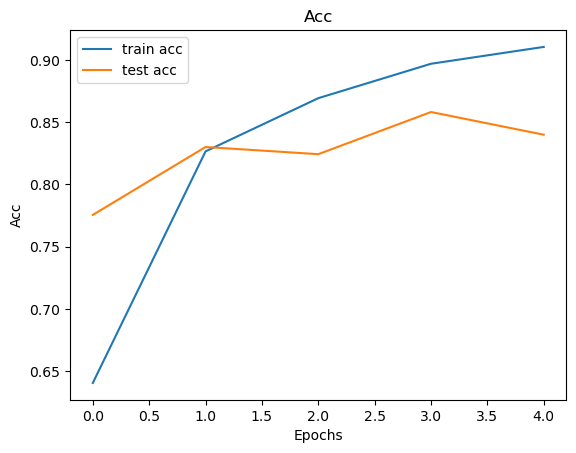

In [22]:
plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label= "test acc")
plt.title("Acc")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend()
plt.show()

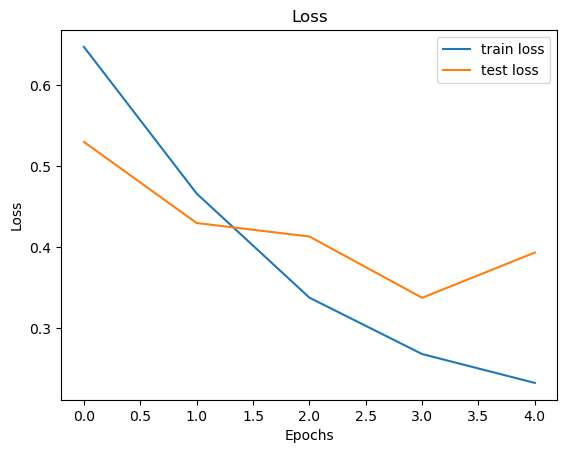

In [23]:
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label= "test loss")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()